σ = (1.08 ± 0.08)
FWHM, измеренный через peak_widths: (2.41 ± 0.18) кГц
Максимум спектра находится в точке x = 478119.24 Гц


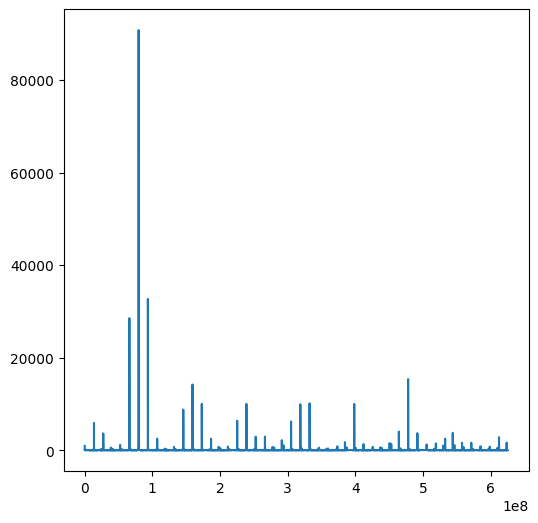

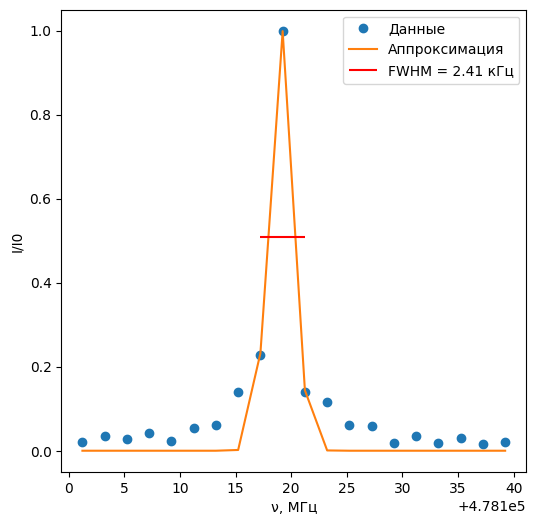

In [37]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks, peak_widths
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('50mks1mSA0.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])
spectr1 = np.linspace(1.4100E-04, 6.4100E-04, 625000)
#spectr1 = np.linspace(-2.0250E-04, -1.9750E-04, 25000)
dt = spectr1[1] - spectr1[0]
fft_signal = np.fft.fft(Spectr1)
fft_signal = fft_signal[:len(fft_signal)//2-1]
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
filtered_signal = savgol_filter(abs(fft_signal), window_length = 5, polyorder = 4)
fft_signal = filtered_signal
plt.figure(figsize=(6,6))
plt.plot(freq, abs(fft_signal))
y_1 = []
x_1 = []
for i in range(len(freq)):
    if (freq[i]>478.1e6) and (freq[i]<478.14e6):
        x_1.append(freq[i]/1e3)
        y_1.append(abs(fft_signal[i]))
y_1 = np.array(y_1)/max(y_1)
x_1 = np.array(x_1)
# Нахождение пиков
peaks, _ = find_peaks(y_1, height=0.5)  # height=0.5 для нахождения пиков выше половины максимума
results_half = peak_widths(y_1, peaks, rel_height=0.5)
# Преобразование ширины пика из индексов в частотные единицы
fwhm_indices = results_half[0]
fwhm_values = fwhm_indices * (x_1[1] - x_1[0])  # Умножаем на шаг по частоте
peak_heights = results_half[1] # Высота, на которой измеряется ширина (полувысота)
left_edges = x_1[np.round(results_half[2]).astype(int)]  # Левая граница FWHM
right_edges = x_1[np.round(results_half[3]).astype(int)]  # Правая граница FWHM
# Для основного пика (если их несколько)
main_peak_fwhm = fwhm_values[0]
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
# Начальные guess-параметры [A, mu, sigma, offset]
initial_guess = [max(y_1), x_1[np.argmax(y_1)], main_peak_fwhm/2.355]
# Вызов curve_fit
params, covariance = curve_fit(gaussian, x_1, y_1, p0=initial_guess)
# Извлечение параметров
A, mu, sigma = params
# Погрешности параметров (стандартные отклонения)
errors = np.sqrt(np.diag(covariance))
A_err, mu_err, sigma_err = errors
fwhm_err = 2.355 * sigma_err
print(f'σ = ({sigma:.2f} ± {sigma_err:.2f})')
print(f'FWHM, измеренный через peak_widths: ({main_peak_fwhm:.2f} ± {fwhm_err:.2f}) кГц')
# Поиск пиков
peaks, _ = find_peaks(y_1)
# Определение максимального пика
max_peak_index = peaks[np.argmax(abs(y_1[peaks]))]
# Значение по оси x для максимального пика
max_x_value = x_1[max_peak_index]
print(f'Максимум спектра находится в точке x = {max_x_value:.2f} Гц')
plt.figure(figsize=(6,6))
plt.plot(x_1, y_1, 'o', label='Данные')
plt.plot(x_1, gaussian(x_1, *params), '-', label='Аппроксимация')
# Линия полувысоты и границы FWHM
plt.hlines(peak_heights, left_edges, right_edges, color="red", label=f"FWHM = {fwhm_values[0]:.2f} кГц")
# Вертикальные линии для границ FWHM
#plt.vlines(left_edges, 0, peak_heights, color="green", alpha=0.7)
#plt.vlines(right_edges, 0, peak_heights, color="green", alpha=0.7)
plt.legend()
plt.xlabel('ν, МГц')
plt.ylabel('I/I0')
plt.show()